In [1]:
#base
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import random
from scipy.spatial import distance
import skbio

In [2]:
warnings.filterwarnings('ignore')
sns.set_theme()

In [ ]:
%cd zkarwowska/AE/

## 1. rad raw and imputed data

In [19]:
mbimpute_df = pd.read_csv('MBIMPUTE/mbimpute_output/impute_rarefied_interpolated_twice_df.csv', index_col = [0])

filtered_df = pd.read_csv('input_for_ae/filtered_data.csv', index_col = [0])
filtered_df  = filtered_df[filtered_df.index.isin(mbimpute_df.index)]
filtered_df.index = filtered_df.index.astype(int)
filtered_df = filtered_df.iloc[:391]

## 2. plot range change

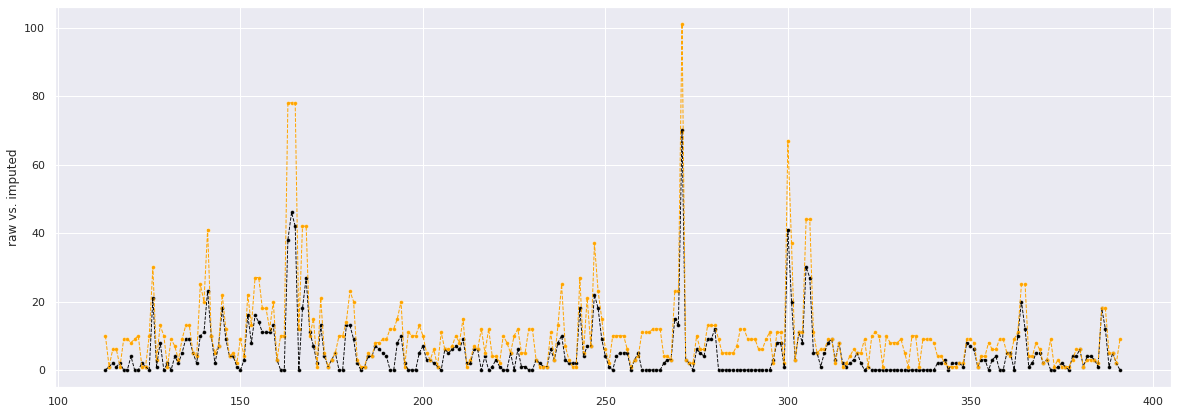

In [207]:
col = 'TACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTTGATAAGTCTGAAGTTAAAGGCTGTGGCTCAACCATAGTTCGC'
plt.figure(figsize = [20, 7])


sns.scatterplot(x = filtered_df.index,
             y = filtered_df[col],
               color = "Black", s = 15)

sns.lineplot(x = filtered_df.index,
             y = filtered_df[col],
            linewidth = .9,
            linestyle = '--',
            color = "Black")

sns.scatterplot(x = mbimpute_df.index,
             y = mbimpute_df[col],
               color = "Orange", s = 15)

sns.lineplot(x = mbimpute_df.index,
             y = mbimpute_df[col],
            linewidth = 1,
            linestyle = '--',
            color = "Orange")

plt.ylabel("raw vs. imputed")
plt.savefig('otu_distribution.png')

## 3. Bray Curtis distance between raw and imputed timepoints

In [166]:
import itertools
from scipy.spatial.distance import pdist


mbimpute_bc = pd.DataFrame(itertools.combinations(mbimpute_df.index, 2), columns=['i','j'])
mbimpute_bc['dist'] = pdist(mbimpute_df, 'braycurtis')

raw_bc = pd.DataFrame(itertools.combinations(filtered_df.index, 2), columns=['i','j'])
raw_bc['dist'] = pdist(filtered_df, 'braycurtis')

In [167]:
mbimpute_idx = sorted(set(mbimpute_bc['i']).union(mbimpute_bc['j']))

mbimputed_distmatrix = (mbimpute_bc.pivot(index='i', columns='j', values='dist')
   .reindex(index=mbimpute_idx, columns=mbimpute_idx)
   .fillna(0, downcast='infer')
   .pipe(lambda x: x+x.values.T)
 )

raw_idx = sorted(set(mbimpute_bc['i']).union(mbimpute_bc['j']))

raw_distmatrix = (raw_bc.pivot(index='i', columns='j', values='dist')
   .reindex(index=raw_idx, columns=raw_idx)
   .fillna(0, downcast='infer')
   .pipe(lambda x: x+x.values.T)
 )

## 4. Mantel's test

In [168]:
import mantel

rho = mantel.test(mbimputed_distmatrix, raw_distmatrix, perms=10000, method='pearson', tail='upper')

In [203]:
rho[1]

0.0001

## 5.  scatterplot between true and imputed BC distances between points

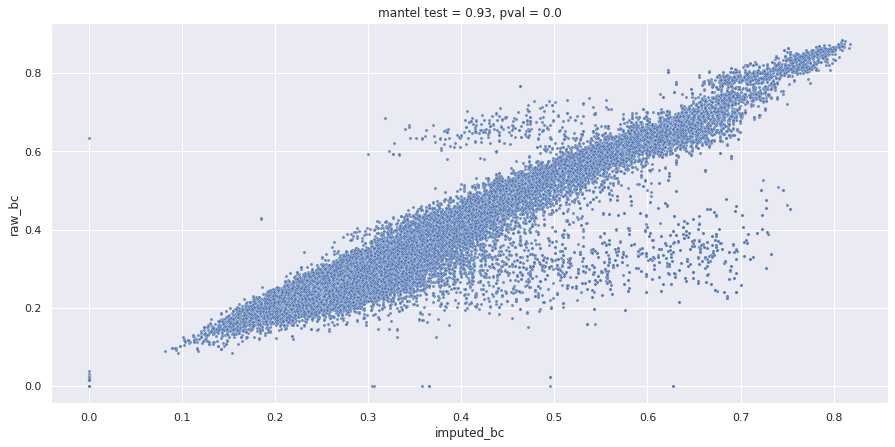

In [206]:
plt.figure(figsize = [15, 7])

sns.scatterplot(
    x = mbimpute_bc['dist'],
    y = raw_bc['dist'],
    s =10,
    alpha = .8
)

plt.xlabel("imputed_bc")
plt.ylabel("raw_bc")
plt.title('mantel test = {}, pval = {}'.format(np.round(rho[0], 3), np.round(rho[1], 3)))
plt.savefig('mantel test.png')

## 6. BC distance between raw an imputed data

In [176]:
BRAY_CURTIS = []

for idx in filtered_df.index:

    y_true = mbimpute_df.loc[idx]
    y_forecasted = raw_df.loc[idx]

    bray_curtis = distance.braycurtis(y_true,
                                      y_forecasted)

    BRAY_CURTIS.append(bray_curtis)

bray_curtis_df = pd.DataFrame(BRAY_CURTIS, columns = ['BC_DISTANCE'])

bray_curtis_df['TIMESTEP'] = filtered_df.index

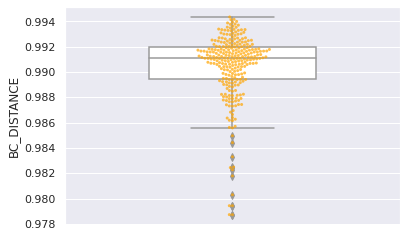

In [194]:
sns.boxplot(
    data = bray_curtis_df
    y = 'BC_DISTANCE',
    orient = 'h',
    width = .5,
    color = 'White'
)
sns.swarmplot(
    data = bray_curtis_df,
    y = 'BC_DISTANCE',
    s = 3,
    color = 'Orange',
    alpha = .7
)

plt.savefig('bc_between_mbimputed_and_filtered_data.png')